## Compare ChebyKAN's ability in function interpolation with MLP

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

from ChebyKANLayer import ChebyKANLayer
from kans import KAN



In [2]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    # noise = np.random.normal(0, 0.2, y.shape)
    # y += noise
    
    return y*1000

In [3]:
# # Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = x-1
        #return self.layers(x-1) # centralize the input
        return self.layers(x) # centralize the input

    
# ChebyKAN
class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 8, 8)
        self.chebykan2 = ChebyKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

In [4]:
# error metrics class for evaluating the error of the solution
class ErrorMetrics:
    def __init__(self, u_pred, u_true):
        self.u_true = u_true
        self.u_pred = u_pred
        self.N = u_true.shape[0]

    def RMSE(self): # root mean squared error
        return np.sqrt(np.mean((self.u_pred - self.u_true)**2))

    def MAE(self): # mean absolute error
        return np.mean(np.abs(self.u_pred - self.u_true))

    def MAPE(self): # mean absolute percentage error
        with np.errstate(divide='ignore'):
            return np.mean(np.abs((self.u_pred - self.u_true)/self.u_true))*100

    def NRMSPE(self): # normalized root mean squared error in percent
        return np.sqrt(np.mean((self.u_pred - self.u_true)**2)/np.mean(self.u_true**2))*100

    def NMAPE(self): # normalized mean absolute error or weighted mean absolute percentage error in percent
        return np.mean(np.abs(self.u_pred - self.u_true)/np.mean(self.u_true))*100

In [5]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Fix random seeds for reproducibility
instance_number = 1
np.random.seed(instance_number)
torch.manual_seed(instance_number) # cpu vars

# set device to train model
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed_all(instance_number)
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Apple MPS is available. Using MPS.")
else:
    device = torch.device("cpu")
    print("Cuda Gpu is not available. Using CPU.")
print('----------------------------------------------------------------------------------------------------------------------------------------------------------------')

# Instantiate models
cheby_model = ChebyKAN()
mlp_model = SimpleMLP()
kan_model = KAN(layers_hidden = [1, 20, 20, 1] , grid_size=10, spline_order=3, base_activation= torch.nn.Tanh).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_kan = torch.optim.Adam(kan_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.02)


# create list to store loss
cheby_losses = []
mlp_losses = []
kan_losses = []


# Train the models
epochs = 200000 #default = 200000
for epoch in range(epochs):
    
    # record start time
    start_time = time.time()

    # KST + Polynomial
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby.backward()
    torch.nn.utils.clip_grad_norm_(cheby_model.parameters(), max_norm=1.0)
    optimizer_cheby.step()
    # MLP
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()
    # KST + Spline
    optimizer_kan.zero_grad()
    outputs_kan = kan_model(x_train)
    loss_kan = criterion(outputs_kan, y_train)
    loss_kan.backward()
    optimizer_kan.step()
   

    # record end time
    end_time = time.time()

    # Calculate epoch duration
    epoch_duration = end_time - start_time

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        kan_losses.append(loss_kan.item())
        
        print(f'Epoch {epoch + 1}/{epochs}, \
              KST + Polynomial Loss: {loss_cheby.item():.4f}, MLP Loss: {loss_mlp.item():.4f}, KST + Spline Loss: {loss_kan.item():.4f}, Time: {epoch_duration:.4f} seconds')



# # Test the models
# x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
# y_pred_cheby = cheby_model(x_test).detach()
# y_pred_mlp = mlp_model(x_test).detach()
# y_pred_ffnn = ffnn_model(x_test).detach()
# y_pred_ffnn_aal = ffnn_aal_model(x_test).detach()

# cheby_u_pred = outputs_cheby.detach().numpy()
# cheby_error_u = ErrorMetrics(cheby_u_pred, y_train) # error_u
# print('ChebyKAN RMSE is:', cheby_error_u.RMSE())

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1).to(device)

cheby_model.eval()
mlp_model.eval()
kan_model.eval()

with torch.no_grad():
    y_pred_cheby = cheby_model(x_test).cpu().detach().numpy()
    y_pred_mlp = mlp_model(x_test).cpu().detach().numpy()
    y_pred_kan = kan_model(x_test).cpu().detach().numpy()
    


Cuda Gpu is not available. Using CPU.
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/200000,               KST + Polynomial Loss: 597528.2500, MLP Loss: 597474.5625, KST + Spline Loss: 597473.8125, Time: 0.0552 seconds
Epoch 101/200000,               KST + Polynomial Loss: 556903.4375, MLP Loss: 184851.3906, KST + Spline Loss: 569345.4375, Time: 0.0235 seconds
Epoch 201/200000,               KST + Polynomial Loss: 519392.7812, MLP Loss: 194390.0469, KST + Spline Loss: 525626.8750, Time: 0.0249 seconds
Epoch 301/200000,               KST + Polynomial Loss: 485684.3125, MLP Loss: 120339.4688, KST + Spline Loss: 434035.3125, Time: 0.0239 seconds
Epoch 401/200000,               KST + Polynomial Loss: 455358.8125, MLP Loss: 111650.1953, KST + Spline Loss: 253784.3125, Time: 0.0234 seconds
Epoch 501/200000,               KST + Polynomial Loss: 427810.1250, MLP Loss: 11607

In [10]:
# Calculate and print errors for ChebyKAN (as an example)
y_test = target_function(x_test.cpu().numpy())

cheby_error_u = ErrorMetrics(y_pred_cheby, y_test)
mlp_error_u = ErrorMetrics(y_pred_mlp, y_test)
kan_error_u = ErrorMetrics(y_pred_kan, y_test)


print('Relative/normalized RMSE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.NRMSPE()))
print('MLP: %.8f' % (mlp_error_u.NRMSPE()))
print('KST + Sp: %.8f' % (kan_error_u.NRMSPE()))
print('\n')


print('Relative/normalized NMAPE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.NMAPE()))
print('MLP: %.8f' % (mlp_error_u.NMAPE()))
print('KST + Spline: %.8f' % (kan_error_u.NMAPE()))
print('\n')


print('MAPE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.MAPE()))
print('MLP: %.8f' % (mlp_error_u.MAPE()))
print('KST + Spline: %.8f' % (kan_error_u.MAPE()))
print('\n')


print('RMSE')
print('KST + Polynomial %.8f' % (cheby_error_u.RMSE()))
print('MLP: %.8f' % (mlp_error_u.RMSE()))
print('KST + Spline: %.8f' % (kan_error_u.RMSE()))
print('\n')


print('MAE')
print('KST + Polynomial: %.8f' % (cheby_error_u.MAE()))
print('MLP: %.8f' % (mlp_error_u.MAE()))
print('KST + Spline: %.8f' % (kan_error_u.MAE()))
print('\n')


Relative/normalized RMSE (percent)
KST + Polynomial: 6.94470555
MLP: 0.91974363
KST + Sp: 3.21364366


Relative/normalized NMAPE (percent)
KST + Polynomial: 10.14596149
MLP: 1.38139045
KST + Spline: 4.10980694


MAPE (percent)
KST + Polynomial: inf
MLP: inf
KST + Spline: inf


RMSE
KST + Polynomial 53.69329071
MLP: 7.11103773
KST + Spline: 24.84642601


MAE
KST + Polynomial: 32.03125000
MLP: 4.36111116
KST + Spline: 12.97484398




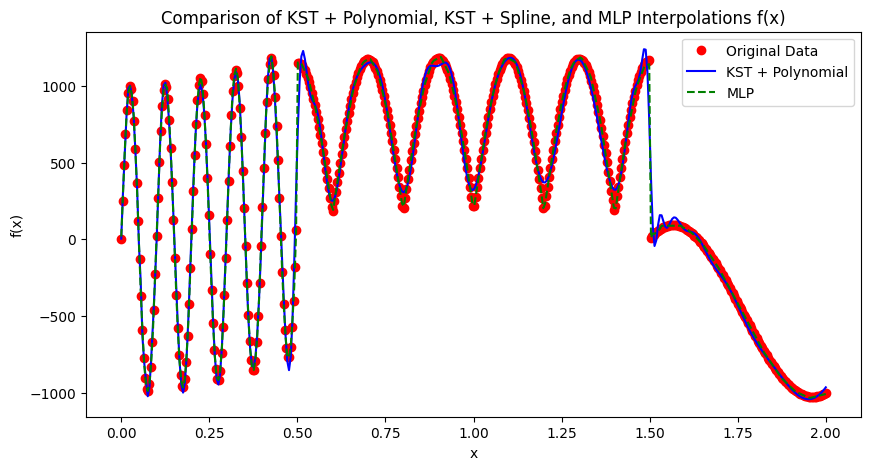

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'ro', label='Original Data')
plt.plot(x_test.cpu().numpy(), y_pred_cheby, 'b-', label='KST + Polynomial')
plt.plot(x_test.cpu().numpy(), y_pred_mlp, 'g--', label='MLP')
plt.plot(x_test.cpu().numpy(), y_pred_kan, 'b-', label='KST + Spline')

plt.title('Comparison of KST + Polynomial, KST + Spline, and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [8]:
if epoch >= 0 and epoch <= 5000:
    lower_xlim = -(epoch * 0.05)
if epoch >= 5001 and epoch <= 60000:
    lower_xlim = -(epoch * 0.01)
if epoch >= 60001:
    lower_xlim = -(epoch * 0.005)
#print(lower_xlim)

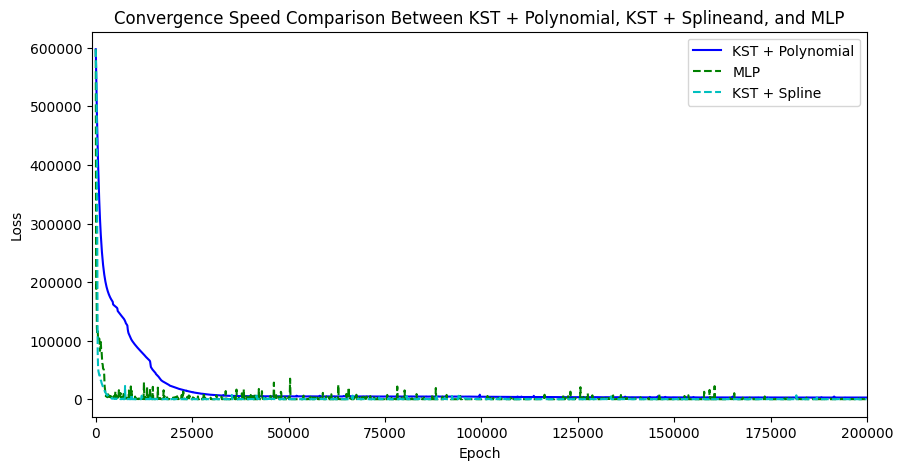

In [9]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), cheby_losses, 'b-', label='KST + Polynomial')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.plot(range(0, epochs, 100), kan_losses, 'c--', label='KST + Spline')

plt.title('Convergence Speed Comparison Between KST + Polynomial, KST + Splineand, and MLP')
plt.xlim(lower_xlim, epochs) # plt.xlim(-1000, 120000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()